In [1]:
import numpy as np
import rerun as rr
import laspy
import os
import open3d as o3d
import matplotlib.pyplot as plt
from collections import Counter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
input_file = os.path.join('..', 'data', 'pcd_wilhelmina_park', 'whm_100x100.LAZ')

# Thinning options
thinning_factor = 1.0  # Set the percentage to keep (1.0 means keep everything)

# Open and read the LAS file
with laspy.open(input_file, laz_backend=laspy.LazBackend.Laszip) as f:
    original_las = f.read()

    # Optionally thin the point cloud
    if 0 < thinning_factor < 1.0:
        print(f"Thinning the point cloud with factor {thinning_factor}...")
        # Downsample the point cloud by step
        step = int(1 / thinning_factor)  # Calculate the step size
        thinned_points = original_las.points[::step]  # Select every nth point
        print(f"Original points: {len(original_las.points)}, Thinned points: {len(thinned_points)}")
        original_las.points = thinned_points
    else:
        print("Thinning not applied. Keeping all points.")

    print("\nPoint Attributes:")
    # Set column width
    col_width = 25  # Adjust this value for better spacing

    # Loop through dimensions
    for dimension in f.header.point_format.dimension_names:
        dtype = original_las[dimension].dtype
        min_val = original_las[dimension].min()
        max_val = original_las[dimension].max()
        print(f"{dimension.ljust(col_width)} {str(dtype).ljust(col_width)} "
              f"Min: {str(min_val).ljust(col_width)} Max: {str(max_val).ljust(col_width)}")


Thinning not applied. Keeping all points.

Point Attributes:
X                         int32                     Min: 506000                    Max: 606000                   
Y                         int32                     Min: 1062000                   Max: 1162000                  
Z                         int32                     Min: -1418                     Max: 27637                    
intensity                 uint16                    Min: 268                       Max: 21690                    
return_number             uint8                     Min: 1                         Max: 11                       
number_of_returns         uint8                     Min: 1                         Max: 11                       
synthetic                 uint8                     Min: 0                         Max: 0                        
key_point                 uint8                     Min: 0                         Max: 0                        
withheld                  u

In [3]:
# Normalize color bands
bit8 = 255
bit16 = 65535

nir_raw = np.array(original_las.nir, dtype=np.float64) / bit8 #original_las.nir.max()
red_raw = np.array(original_las.red, dtype=np.float64) / bit8 #original_las.red.max()
green_raw = np.array(original_las.green, dtype=np.float64) / bit8 #original_las.green.max()
blue_raw = np.array(original_las.blue, dtype=np.float64) / bit8 #original_las.blue.max()

In [4]:
#function to get the ndvi values
def get_ndvi(red, nir):
    red = np.array(red, dtype=np.float64)
    nir = np.array(nir, dtype=np.float64)
    
    return (nir - red) / (nir+ red + 1e-8)

def get_norm_g(red, green, blue):
    red = np.array(red, dtype=np.float64)
    green = np.array(green, dtype=np.float64)
    blue = np.array(blue, dtype=np.float64)

    return green / (red + green + blue)

def get_mtvi2(nir, red, green):
    nir = np.array(nir, dtype=np.float64)
    red = np.array(red, dtype=np.float64)
    green = np.array(green, dtype=np.float64)
    
    return 1.5 * (1.2 * (nir - green) - 2.5 * (red - green)) / np.sqrt((2 * nir + 1)**2 - (6 * nir - 5 * np.sqrt(red) - 0.5))


In [5]:
#calculate vegetation features and add it to the las attributes
#overwrite potentially existing features

if 'ndvi' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='ndvi', type=np.float32))

# Assign the NDVI values
original_las.ndvi = get_ndvi(red_raw, nir_raw)
ndvi_raw = original_las.ndvi

if 'norm_g' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='norm_g', type=np.float32))

# Assign the normalized green values
original_las.norm_g = get_norm_g(red_raw, green_raw, blue_raw)
norm_g_raw = original_las.norm_g

if 'mtvi2' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='mtvi2', type=np.float32))

# Assign the normalized green values
original_las.mtvi2 = get_norm_g(nir_raw, red_raw, green_raw)
norm_g_raw = original_las.mtvi2

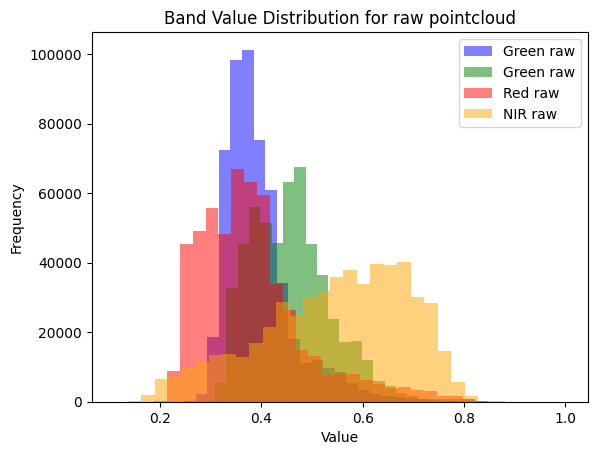

blue band:	max =	0.9803921568627451	min = 0.24705882352941178
green band:	max =	1.0	min = 0.28627450980392155
red band:	max =	1.0	min = 0.18823529411764706
nir band:	max =	0.9607843137254902	min = 0.10980392156862745


In [6]:
#debugging for NDVI values being between -.4 and .4 instead of -1 and 1
bins = 32
alpha = .5

plt.hist(blue_raw, bins=bins, alpha=alpha, label='Green raw', color='blue')
plt.hist(green_raw, bins=bins, alpha=alpha, label='Green raw', color='green')
plt.hist(red_raw, bins=bins, alpha=alpha, label='Red raw', color='red')
plt.hist(nir_raw, bins=bins, alpha=alpha, label='NIR raw', color='orange')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Band Value Distribution for raw pointcloud')
plt.legend()
plt.show()

print(f'blue band:\tmax =\t{blue_raw.max()}\tmin = {blue_raw.min()}')
print(f'green band:\tmax =\t{green_raw.max()}\tmin = {green_raw.min()}')
print(f'red band:\tmax =\t{red_raw.max()}\tmin = {red_raw.min()}')
print(f'nir band:\tmax =\t{nir_raw.max()}\tmin = {nir_raw.min()}')


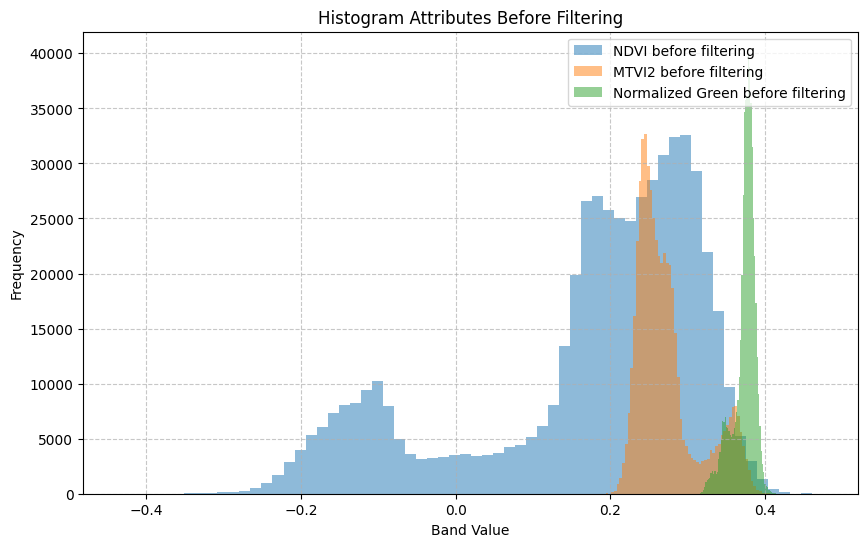

NDVI before filtering:
  Min value: -0.4363636374473572
  Max value: 0.4751131236553192

MTVI2 before filtering:
  Min value: 0.18709677457809448
  Max value: 0.41342756152153015

Normalized Green before filtering:
  Min value: 0.31134021282196045
  Max value: 0.4177215099334717



In [23]:
def plot_combined_histogram(band_values_dict, name='<No Name>'):
    """
    Plot a combined histogram for multiple arrays.
    
    Args:
        band_values_dict (dict): A dictionary where keys are labels and values are arrays to plot.
        name (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot each array in the dictionary
    for label, band_values in band_values_dict.items():
        plt.hist(band_values, bins=64, alpha=0.5, label=label, histtype='stepfilled')
    
    # Add plot details
    plt.title(f"Histogram {name}")
    plt.xlabel("Band Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()
    
    # Print summary statistics
    for label, band_values in band_values_dict.items():
        print(f"{label}:")
        print(f"  Min value: {min(band_values)}")
        print(f"  Max value: {max(band_values)}\n")

# Prepare data for the combined histogram
band_values_dict = {
    'NDVI before filtering': original_las.ndvi,
    'MTVI2 before filtering': original_las.mtvi2,
    'Normalized Green before filtering': original_las.norm_g
}

# Plot the combined histogram
plot_combined_histogram(band_values_dict, name="Attributes Before Filtering")


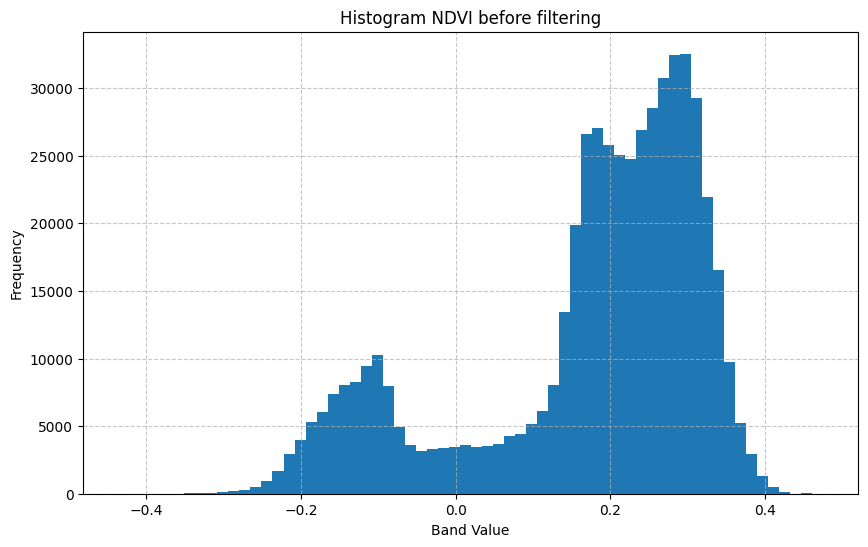

 min value: -0.4363636374473572
 max value: 0.4751131236553192


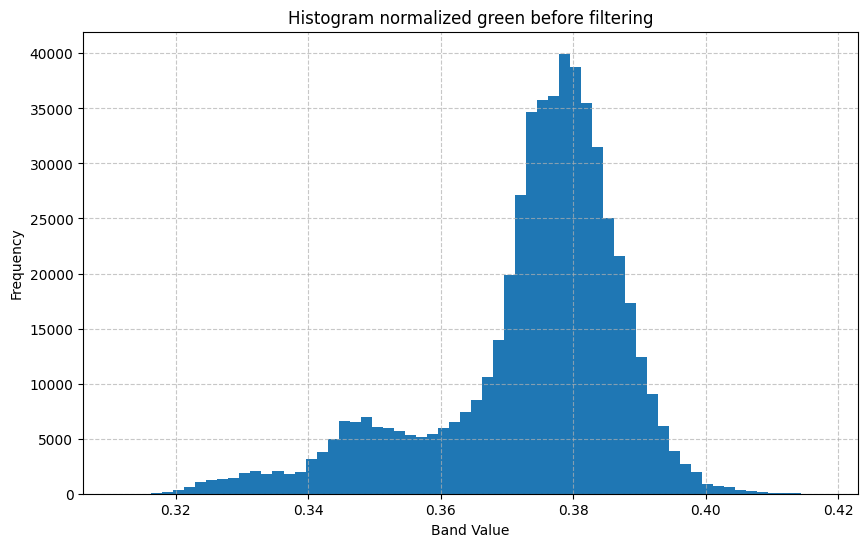

 min value: 0.31134021282196045
 max value: 0.4177215099334717


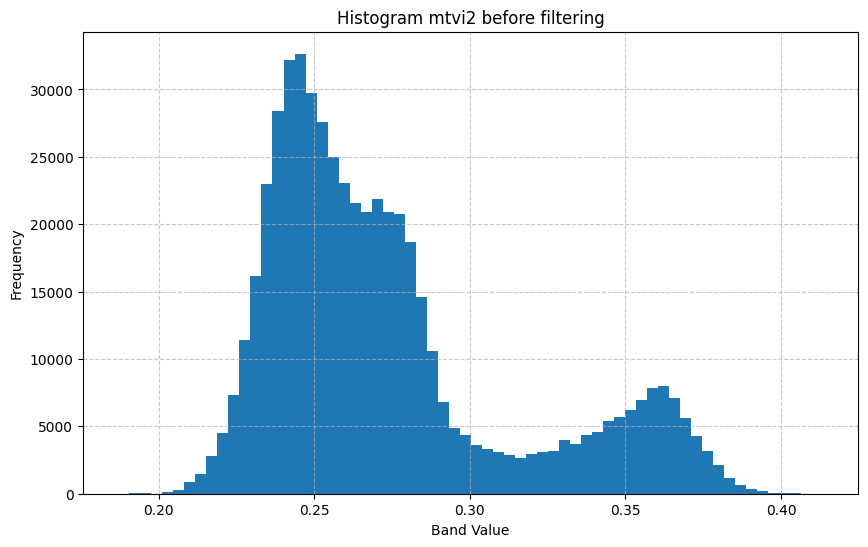

 min value: 0.18709677457809448
 max value: 0.41342756152153015


In [7]:
def plot_histogram(band_values, name='<No Name>'):
    """Plot a histogram of NDVI values."""
    plt.figure(figsize=(10, 6))
    plt.hist(band_values, bins=64)#, linewidth=.5, edgecolor='black')
    plt.title(f"Histogram {name}")
    plt.xlabel("Band Value")
    plt.ylabel("Frequency")
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

    print(f' min value: {min(band_values)}')
    print(f' max value: {max(band_values)}')

plot_histogram(original_las.ndvi, 'NDVI before filtering')
plot_histogram(original_las.norm_g, 'normalized green before filtering')
plot_histogram(original_las.mtvi2, 'mtvi2 before filtering')

In [8]:
# Mapping AHN classification codes to their meanings
AHN_classification_mapping = {
    0: "Created, never classified",
    1: "Unclassified",
    2: "Ground",
    6: "Building",
    9: "Water",
    14: "High tension",
    26: "Civil structure"
}

# Extract classification values from the LAS file
classification_values = original_las.classification

# Print unique classification values and their meanings
unique_values = np.unique(classification_values)
print("Unique Classification Values and Meanings:")
for value in unique_values:
    meaning = AHN_classification_mapping.get(value, "Unknown")  # Handle unknown classifications
    print(f"Class {value}:\t{meaning}")

# Count the occurrences of each classification
counts = Counter(classification_values)

# Sort the classifications by count in descending order
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Display the classification counts in a tabular format
print("\nClassification Counts (Ordered by Frequency):")

# Define column widths for alignment
class_col_width = 10  
meaning_col_width = 25  
count_col_width = 15  

# Print header
print(f"{'Class'.ljust(class_col_width)} {'Meaning'.ljust(meaning_col_width)} {'Points'.rjust(count_col_width)}")
print("-" * (class_col_width + meaning_col_width + count_col_width + 5))

# Print the counts for each classification
for cls, count in sorted_counts:
    meaning = AHN_classification_mapping.get(cls, "Unknown")
    print(f"{str(cls).ljust(class_col_width)} {meaning.ljust(meaning_col_width)} {str(count).rjust(count_col_width)}")


Unique Classification Values and Meanings:
Class 1:	Unclassified
Class 2:	Ground
Class 6:	Building
Class 9:	Water

Classification Counts (Ordered by Frequency):
Class      Meaning                            Points
-------------------------------------------------------
1          Unclassified                       262103
2          Ground                             239680
6          Building                            37182
9          Water                                  31


## Below the filtering of the pointcloud takes place

In [9]:
#create copy of las_original to perform filtering on the copy (called las for simplicity)
las = laspy.LasData(original_las.header)
las.points = original_las.points.copy()

#Filter to keep only Unclassified points
# las = las[las.classification == 1]

#Filter out points with NDVI value under threshold
# ndvi_threshold = 0.0
# las = las[las.ndvi > ndvi_threshold]

#Filter out points with normalised green value under threshold
# norm_g_threshold = 0.36
# las = las[las.norm_g > norm_g_threshold]

#Filter out points with mtvi2 value under threshold
# mtvi2_threshold = 0.32
# las = las[las.mtvi2 > mtvi2_threshold]

#Remove points with single return
las = las[las.number_of_returns > 1]

#Remove last return of all remaining points
las = las[las.return_number != las.number_of_returns]


In [11]:
# Remove outliers using SOR
def remove_outliers(las_data, nb_neighbors=20, std_ratio=2.0):
    # Convert LAS data to Open3D point cloud
    xyz = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)

    # Perform statistical outlier removal
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    
    # Filter the original LAS data
    filtered_las = las_data[ind]
    
    return filtered_las

# After your previous filtering steps:
las = remove_outliers(las, 20, 2.0)

In [12]:
def normalize_array(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [39]:
# Save bands in numpy arrays for furhter use
nir_new = np.array(las.nir, dtype=np.float64) / bit8 # las.nir.max()
red_new = np.array(las.red, dtype=np.float64) / bit8 #las.red.max()
green_new = np.array(las.green, dtype=np.float64) / bit8 #las.green.max()
blue_new = np.array(las.blue, dtype=np.float64) / bit8 #las.blue.max()

ndvi_new = np.array(las.ndvi, dtype=np.float64)

print(f'nir values:\tmin = {nir_new.min()}\tmax = {nir_new.max()}')
print(f'red values:\tmin = {red_new.min()}\tmax = {red_new.max()}')
print(f'green values:\tmin = {green_new.min()}\tmax = {green_new.max()}')
print(f'blue values:\tmin = {blue_new.min()}\tmax = {blue_new.max()}')
print(f'ndvi values:\tmin = {ndvi_new.min()}\tmax = {ndvi_new.max()}')

nir values:	min = 0.21568627450980393	max = 0.8627450980392157
red values:	min = 0.18823529411764706	max = 0.7647058823529411
green values:	min = 0.28627450980392155	max = 0.7843137254901961
blue values:	min = 0.24705882352941178	max = 0.6980392156862745
ndvi values:	min = 0.003215434029698372	max = 0.4751131236553192


In [15]:
def apply_colormap(values, colormap_name="viridis"):
    """
    Apply a colormap to a normalized array of values.
    Args:
        values (np.ndarray): Normalized array of values in the range [0, 1].
        colormap_name (str): Name of the colormap to use.
    Returns:
        np.ndarray: Nx3 array of RGB colors.
    """
    cmap = plt.get_cmap(colormap_name)
    return cmap(values)[:, :3]  # Extract RGB (ignore alpha)

In [41]:
def visualize_pcd_ndvi_nir_red(las_data):
    # Initialize rerun
    rr.init("NDVI, NIR, Red", spawn=True)

    # Disable labels before running your visualization
    rr.config.set_option("view_labels", False)
    
    # Get point coordinates for the two pointclouds
    points = np.column_stack((las_data.x, las_data.y, las_data.z))

    #calculate ndvi values
    ndvi_values = get_ndvi(las_data.red, las_data.nir)
    
    # Normalize NIR and Red values to 0-1 range     BTW this is max FOUND values not max possible
    red_norm = normalize_array(las_data.red)
    nir_norm = normalize_array(las_data.nir)
    

    # Create color array: Red channel for Red values, Green for NDVI, Blue for NIR
    colors = np.column_stack(((ndvi_values + 1) / 2, # NDVI is already in [-1, 1] range, normalize to [0, 1]
                              red_norm,
                              nir_norm
                            ))

    # Log the point cloud to rerun
    rr.log("point_cloud", rr.Points3D(positions=points,
                                        colors=colors,
                                        radii=.5,  # Adjust point size as needed
                                        labels=[f"NDVI: {ndvi:.3f}, NIR: {nir:.3f}, Red: {red:.3f}" 
                                                for ndvi, nir, red in zip(ndvi_values, las_data.nir, las_data.red)]))

    # Log some text to provide context
    rr.log("info", rr.TextLog("Point cloud: Red channel = Red band, Green channel = NDVI, Blue channel = NIR band. Hover for values."))

    print(f"Visualization ready. Run 'rerun' in terminal to view.")

Visualization ready. Run 'rerun' in terminal to view.


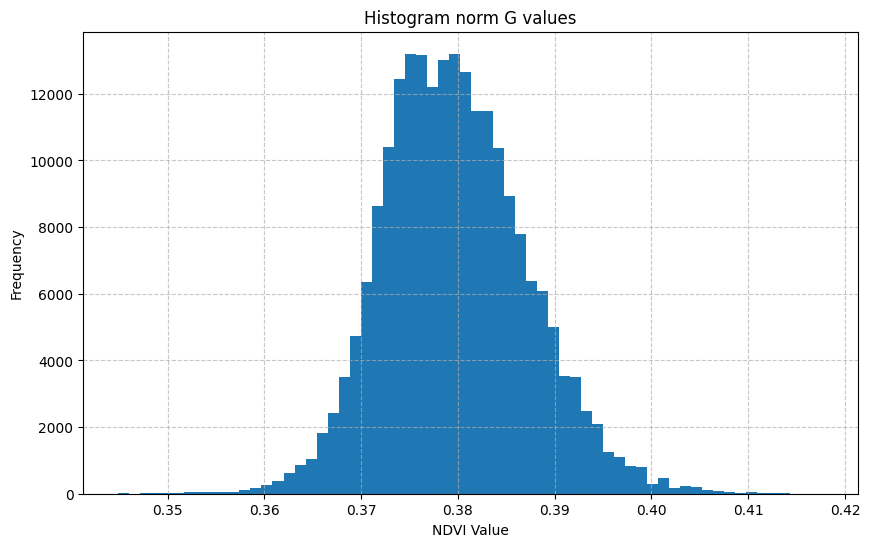

 min value: 0.3449023962020874
 max value: 0.4177215099334717


In [42]:
def visualize_pcd_norm_G(las_data, las_original=None):
    # Initialize rerun
    rr.init("Norm_G", spawn=True)
    
    # Get point coordinates for the two pointclouds
    if las_original:
        points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
        colors_original = np.column_stack((normalize_array(las_original.red), 
                                            normalize_array(las_original.green),
                                            normalize_array(las_original.blue)))

    points = np.column_stack((las_data.x, las_data.y, las_data.z))
    
    # Normalize values
    norm_g_norm = normalize_array(las_data.norm_g)

    # Apply Viridis colormap to norm_g_norm
    colors = apply_colormap(norm_g_norm)

    # Log the point cloud to rerun
    rr.log("norm_g_viridis", rr.Points3D(positions=points,
                                      colors=colors,
                                      radii=.2,  # Adjust point size as needed
                                      labels=[f"Norm_G: {ng:.3f}" for ng in las_data.norm_g]))
    
    
    # Log the original point cloud
    rr.log("original_pdc_RGB", rr.Points3D( positions=points_original,
                                                colors=colors_original,
                                                radii=.2,
                                    labels=[f"Norm_G: {ng:.3f}" for ng in las_data.norm_g]))

    # Log some text to provide context
    rr.log("info", rr.TextLog("Point cloud: Norm G values with Viridis colormap"))

    print(f"Visualization ready. Run 'rerun' in terminal to view.")

visualize_pcd_norm_G(las, las_original=original_las)

# plot_histogram(las.norm_g, 'norm G values')


In [41]:
def labels_list(las):
    # return [f"NDVI: {ndvi:.3f}, NIR: {nir:.3f}, Red: {red:.3f}, Green: {green:.3f}, Blue: {blue:.3f}"
    #         for ndvi, nir, red, green, blue in zip(las.ndvi, las.nir, las.red, las.green, las.blue)]

    return [f"NDVI: {ndvi:.3f}, norm_green: {ng:.3f}, mtvi2: {mtvi2:.3f}"
            for ndvi, ng, mtvi2 in zip(las.ndvi, las.norm_g, las.mtvi2)]
    


def visualize_pcd_filtered_vs_original(las_filtered, las_original):
    # Initialize rerun
    rr.init("Filtered AND Original", spawn=True)
    
    # Get point coordinates for the two pointclouds
    points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
    points_filtered = np.column_stack((las_filtered.x, las_filtered.y, las_filtered.z))

    # Make original pointcloud white
    # colors_original = np.ones((len(points_original), 3))

    # make original pointcloud original RGB values
    colors_original = np.column_stack((normalize_array(las_original.red), 
                                       normalize_array(las_original.green),
                                       normalize_array(las_original.blue)))

    #add alpha to original points
    # alpha_value = 0.5
    # colors_original = np.column_stack((colors_original, np.full(colors_original.shape[0], alpha_value)))


    colors_filtered = apply_colormap(normalize_array(las.mtvi2))

    #add alpha to filtered points
    alpha_value = 0.8
    colors_filtered = np.column_stack((colors_filtered, np.full(colors_filtered.shape[0], alpha_value)))

    # Make filtered pointcloud green
    # colors_filtered = np.column_stack(( np.zeros(len(points_filtered)),
    #                                     np.ones(len(points_filtered)),
    #                                     np.zeros(len(points_filtered))))



    # Log the original point cloud
    rr.log("original_point_cloud", rr.Points3D( positions=points_original,
                                                colors=colors_original,
                                                radii=.2,
                                                labels= labels_list(las_original)))

    # Log the filtered point cloud
    rr.log("filtered_point_cloud", rr.Points3D( positions=points_filtered,
                                                colors=colors_filtered,
                                                radii=.4, #slightly larger than original for visualization 
                                                labels=labels_list(las_filtered))) 

    print(f"Visualization ready. Run 'rerun' in terminal to view.")


In [43]:
def labels_list(las):
    return [f"NDVI: {ndvi:.3f}, norm_green: {ng:.3f}, mtvi2: {mtvi2:.3f}"
            for ndvi, ng, mtvi2 in zip(las.ndvi, las.norm_g, las.mtvi2)]
    


def visualize_multiple_values(las_filtered, las_original, values_to_show_dict):
    # Initialize rerun
    rr.init("Multiple attribute window", spawn=True)
    
    # Get point coordinates for the two pointclouds
    points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
    points_filtered = np.column_stack((las_filtered.x, las_filtered.y, las_filtered.z))
  

    # make original pointcloud original RGB values
    colors_original = np.column_stack((normalize_array(las_original.red), 
                                       normalize_array(las_original.green),
                                       normalize_array(las_original.blue)))


    # Log the original point cloud
    rr.log("original_point_cloud", rr.Points3D( positions=points_original,
                                                colors=colors_original,
                                                radii=.1,
                                                labels= labels_list(las_original)))



    for name, values in values_to_show_dict.items():


        colors_filtered = apply_colormap(normalize_array(values))

        #add alpha to filtered points
        # alpha_value = 0.8
        # colors_filtered = np.column_stack((colors_filtered, np.full(colors_filtered.shape[0], alpha_value)))


        # Log the filtered point cloud
        rr.log(f"values for {name}", rr.Points3D( positions=points_filtered,
                                                    colors=colors_filtered,
                                                    radii=.2, #slightly larger than original for visualization 
                                                    labels=labels_list(las_filtered))) 

    print(f"Visualization ready. Run 'rerun' in terminal to view.")


show_dict = {'ndvi': las.ndvi,
             'norm_g' : las.norm_g,
             'mtvi2' : las.mtvi2}

visualize_multiple_values(las, original_las, show_dict)

Visualization ready. Run 'rerun' in terminal to view.


In [44]:
def visualize_with_dynamic_colormaps(las_filtered, las_original, attributes_dict):
    # Initialize rerun
    rr.init("Dynamic Attributes Viewer", spawn=True)
    
    # Get point coordinates for the original and filtered point clouds
    points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
    points_filtered = np.column_stack((las_filtered.x, las_filtered.y, las_filtered.z))

    # Original point cloud with RGB colors
    colors_original = np.column_stack((
        normalize_array(las_original.red),
        normalize_array(las_original.green),
        normalize_array(las_original.blue)
    ))

    # Log the original point cloud
    rr.log("original_point_cloud", rr.Points3D(
        positions=points_original,
        colors=colors_original,
        radii=0.1,
        labels=labels_list(las_original)
    ))

    # Filtered point cloud with dynamic attributes
    for name, values in attributes_dict.items():
        normalized_values = normalize_array(values)
        attribute_colors = apply_colormap(normalized_values)
        
        # Log the filtered point cloud with the specific attribute
        rr.log(f"filtered_point_cloud_{name}", rr.Points3D(
            positions=points_filtered,
            colors=attribute_colors,
            radii=0.2,  # Slightly larger for visualization
            labels=labels_list(las_filtered)
        ))

    print(f"Visualization ready. Run 'rerun' in terminal to view.")


# Define attributes to visualize
attributes_to_show = {
    "NDVI": las.ndvi,
    "Normalized Green": las.norm_g,
    "MTVI2": las.mtvi2
}

# Call the visualization function
visualize_with_dynamic_colormaps(las, original_las, attributes_to_show)


AttributeError: module 'rerun' has no attribute 'ColorMap'

In [42]:
# visualize_pcd_ndvi_nir_red(las)
visualize_pcd_filtered_vs_original(las, original_las)

# plot_histogram(las.ndvi, name='ndvi after filtering')
# plot_histogram(las.norm_g, name='normalised green after filtering')
# plot_histogram(las.mtvi2, name='mtvi2 after filtering')

Visualization ready. Run 'rerun' in terminal to view.


In [ ]:
# save the filtered pointcloud

las.write(os.path.join('..', 'data', "pcd_wilhelmina_park", "filtered_test_001.laz"))

# Continue with Open3D to calculate and output alpha shape

In [20]:
# # Load points
# points = np.vstack((las.x, las.y, las.z)).transpose()
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points)

# # Optional: Downsample the point cloud if it's too large
# # voxel_size = 0.05  # Adjust this value as needed
# # pcd = pcd.voxel_down_sample(voxel_size)

In [ ]:
# # Cluster the point cloud using DBSCAN
# eps = 1.5  # Adjust this value based on your data
# min_points = 10  # Minimum number of points to form a cluster
# labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))

# # Get the number of clusters (excluding noise, which is labeled as -1)
# max_label = labels.max()
# print(f"Number of clusters: {max_label + 1}")


Number of clusters: 34


In [ ]:
# # DEBUG: Visualize a specific cluster (e.g., cluster 0)
# cluster_points = pcd.select_by_index(np.where(labels == 500)[0])
# o3d.visualization.draw_geometries([cluster_points])

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
